In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [93]:
data= pd.read_csv('/home/varun/Desktop/FEDFUNDS.csv', parse_dates=True, index_col='DATE')
data.columns=['FED_Rates']

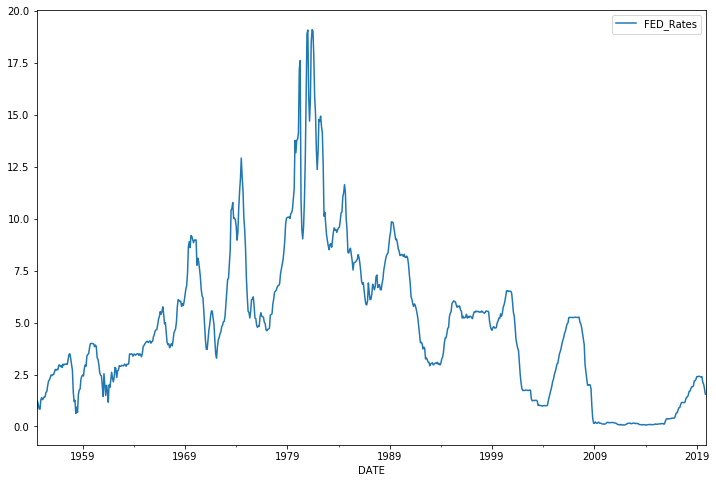

In [94]:
data.plot(figsize=(12,8))

In [95]:
#Using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
X_dickey=data.values
result = adfuller(X_dickey)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.743708
p-value: 0.066775
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [96]:
"""
    Here, ADF value is greater than the critical value
    SO NULL Hypothesis is accepted 
    i.e The Dataset is non-Stationary
"""

'\n    Here, ADF value is greater than the critical value\n    SO NULL Hypothesis is accepted \n    i.e The Dataset is non-Stationary\n'

In [97]:
#Cuberoot Transform to  the dataset to make it Stationary
import math
X_dickey=data.values
X_dickey=np.cbrt(X_dickey)
result = adfuller(X_dickey)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.234981
p-value: 0.193795
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [98]:
"""
    Even after applying log, sqrt, cbrt the data is non-stationary
"""

'\n    Even after applying log, sqrt, cbrt the data is non-stationary\n'

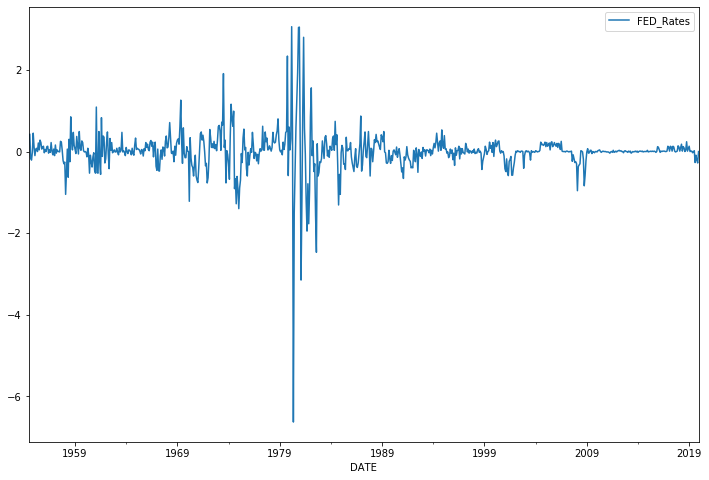

In [99]:
data=data.diff()
data.plot(figsize=(12,8))

In [67]:
nan_value=float("NaN")
data.replace("", nan_value, inplace=True)
data.dropna(subset = ["FED_Rates"], inplace=True)

In [68]:
#Using Augmented Dickey-Fuller test
X_dickey=data.values
result = adfuller(X_dickey)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.206656
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [69]:
"""
    After, Applying the Diffrence to the data
    Stationary Dataset is achieved
"""

'\n    After, Applying the Diffrence to the data\n    Stationary Dataset is achieved\n'

In [70]:
#Creating a test and training data set
test_size=20
test_ind=len(data)-test_size

In [71]:
train=data.iloc[:test_ind]
test=data.iloc[test_ind:]

In [72]:
"""Normalizing the data to feed the network"""
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train)
scaled_training_dataset=scaler.transform(train)
scaler_test_dataset=scaler.transform(test)

In [73]:
"""Using TimeSeries Generator to transform the data"""
from keras.preprocessing.sequence import TimeseriesGenerator
length=10
generator=TimeseriesGenerator(scaled_training_dataset,scaled_training_dataset,length=length, batch_size=1)

In [74]:
#Creating the model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, BatchNormalization, Dense,Activation
feature=1
#Creating the model
model=Sequential()
model.add(LSTM(units=100,input_shape=(length,feature)))
model.add(Activation('relu'))
model.add(Dense(units=1))    

model.compile(optimizer='adam',
              loss='mean_squared_error')

In [75]:
from keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)
#Using timeseries Generator for the test dataset
validation_generator=TimeseriesGenerator(scaler_test_dataset,scaler_test_dataset,length=length,batch_size=1)

In [76]:
model.fit_generator(generator,epochs=20,validation_data=validation_generator)

Epoch 1/20
755/755 [==============================] - 4s 6ms/step - loss: 0.0070 - val_loss: 4.4842e-04
Epoch 2/20
755/755 [==============================] - 4s 5ms/step - loss: 0.0035 - val_loss: 2.8185e-04
Epoch 3/20
755/755 [==============================] - 4s 6ms/step - loss: 0.0033 - val_loss: 1.5057e-06
Epoch 4/20
755/755 [==============================] - 4s 5ms/step - loss: 0.0032 - val_loss: 1.5242e-05
Epoch 5/20
755/755 [==============================] - 4s 6ms/step - loss: 0.0031 - val_loss: 9.0138e-04
Epoch 6/20
755/755 [==============================] - 4s 5ms/step - loss: 0.0030 - val_loss: 5.7155e-04
Epoch 7/20
755/755 [==============================] - 4s 5ms/step - loss: 0.0030 - val_loss: 2.3721e-05
Epoch 8/20
755/755 [==============================] - 4s 5ms/step - loss: 0.0029 - val_loss: 1.2286e-04
Epoch 9/20
755/755 [==============================] - 4s 6ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 10/20
755/755 [==============================] - 4s 5ms/step -

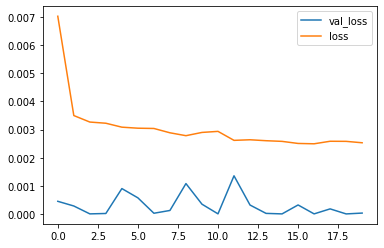

In [77]:
metrics=pd.DataFrame(model.history.history)
metrics.plot()

In [78]:
"""Testing the model to predict the test data which we created earlier"""
test_pred=[]
first_eval_batch=scaled_training_dataset[-length:]
current_batch=first_eval_batch.reshape((1,length,feature))

for i in range(len(test)):
    #predicting the one by one data in the test data to compare of after
    current_pred= model.predict(current_batch)[0]
    
    test_pred.append(current_pred)
    #UPdating the cureent batch
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [79]:
#Converting the predicited data in its true form
true_pred=scaler.inverse_transform(test_pred)
test['Prediction']=true_pred


/home/varun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
test

,FED_Rates,Prediction
DATE,,
2018-05-01,0.01,0.080755
2018-06-01,0.12,0.031798
2018-07-01,0.09,0.028880
2018-08-01,0.00,0.030306
2018-09-01,0.04,0.032810
2018-10-01,0.24,0.034252
2018-11-01,0.01,0.034389
2018-12-01,0.07,0.034035
2019-01-01,0.13,0.034016


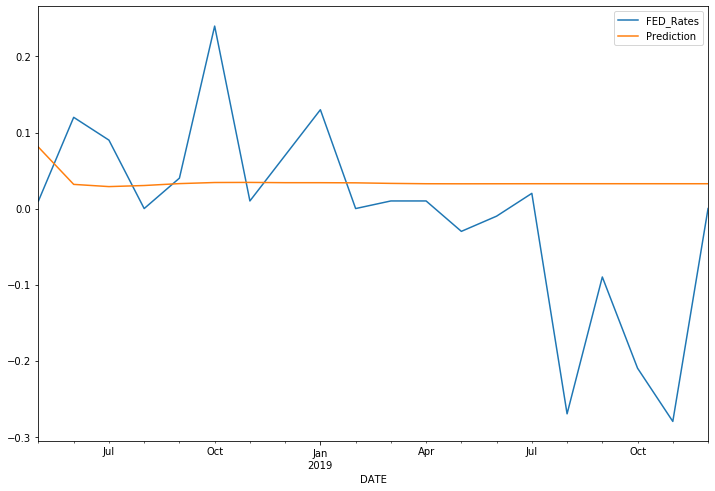

In [81]:
test.plot(figsize=(12,8))

In [82]:
#Sccaling/Normalizing the whole dataset
full_scaler=MinMaxScaler()
scaled_full_dataset=full_scaler.fit_transform(data)

In [83]:
length=12
generator=TimeseriesGenerator(scaled_full_dataset,scaled_full_dataset,length=length,batch_size=1)


In [84]:
#Creating the model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, BatchNormalization, Dense,Activation
feature=1
#Creating the model
model=Sequential()
model.add(LSTM(units=100,input_shape=(length,feature)))
model.add(Activation('relu'))
model.add(Dense(units=1))    

model.compile(optimizer='adam',
              loss='mean_squared_error')
model.fit_generator(generator,epochs=10)

Epoch 1/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0077
Epoch 2/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0034
Epoch 3/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0033
Epoch 4/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0031
Epoch 5/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0030
Epoch 6/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0029
Epoch 7/10
773/773 [==============================] - 4s 6ms/step - loss: 0.0030
Epoch 8/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0028
Epoch 9/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0029
Epoch 10/10
773/773 [==============================] - 5s 6ms/step - loss: 0.0028


In [85]:
"""Forecasting the data in the future using the mode"""
forecast=[]
#User can determine the time period into the future till user want to predict the data/Trend
period=12

first_eval_batch=scaled_full_dataset[-length:]
current_batch=first_eval_batch.reshape((1,length,feature))

for i in range(period):
    current_pred=model.predict(current_batch)[0]
    forecast.append(current_pred)
    
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    

In [86]:
forecast=scaler.inverse_transform(forecast)

In [87]:
forecast_index=pd.date_range(start='2020-01-01',periods=period,freq="MS")

In [88]:
forecast_index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [89]:
forecast_df=pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

In [90]:
forecast_df

,Forecast
2020-01-01,-0.459338
2020-02-01,-0.516396
2020-03-01,-0.521731
2020-04-01,-0.529668
2020-05-01,-0.534509
2020-06-01,-0.538365
2020-07-01,-0.541530
2020-08-01,-0.544335
2020-09-01,-0.546039
2020-10-01,-0.547888


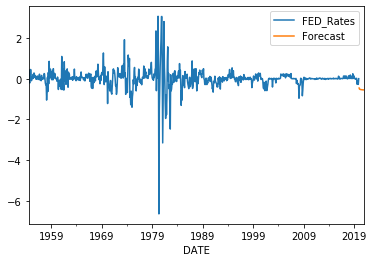

In [91]:
ax=data.plot()
forecast_df.plot(ax=ax)
